In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
print('Tensorflow version: %s' % str(tf.__version__))

import sys
import os
if sys.platform.startswith('darwin'):
    print('Enable multiple instances of OpenMP on macOS')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import pathlib

Tensorflow version: 2.0.0
Enable multiple instances of OpenMP on macOS


In [2]:
print('Download data')
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print('Saved data into file', dataset_path)

Download data
Saved data into file /Users/hzhou/.keras/datasets/auto-mpg.data


In [3]:
print('Load data by using pandas')
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

print('Data shape:',str(dataset.shape))

print('Show last items of data')
dataset.tail()

Load data by using pandas
Data shape: (398, 8)
Show last items of data


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
print('Drop N/A data')
dataset = dataset.dropna()
print('Now the data shape becomes', str(dataset.shape))

Drop N/A data
Now the data shape becomes (392, 8)


In [5]:
print('Split origin column into different contries')
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

Split origin column into different contries


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [6]:
print('Split dataset into training and test subsets')
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print('Training shape', str(train_dataset.shape), 'test shape', str(test_dataset.shape))

Split dataset into training and test subsets
Training shape (314, 10) test shape (78, 10)


Analyse the joint distribution of columns


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


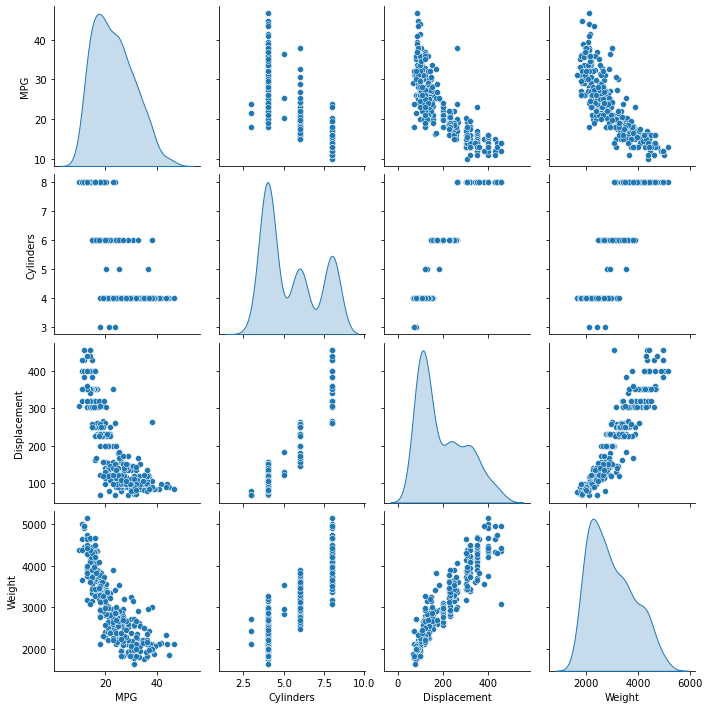

In [7]:
print('Analyse the joint distribution of columns')
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

train_stats = train_dataset.describe().transpose()
train_stats

In [8]:
print('Normalize data')
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Normalize data


In [9]:
print('Prepare model')
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])
model.compile(loss='mse',
            optimizer=tf.keras.optimizers.RMSprop(0.001),
            metrics=['mae', 'mse'])
model.summary()

Prepare model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('Train the model')

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

Train the model

..............................................

Show history


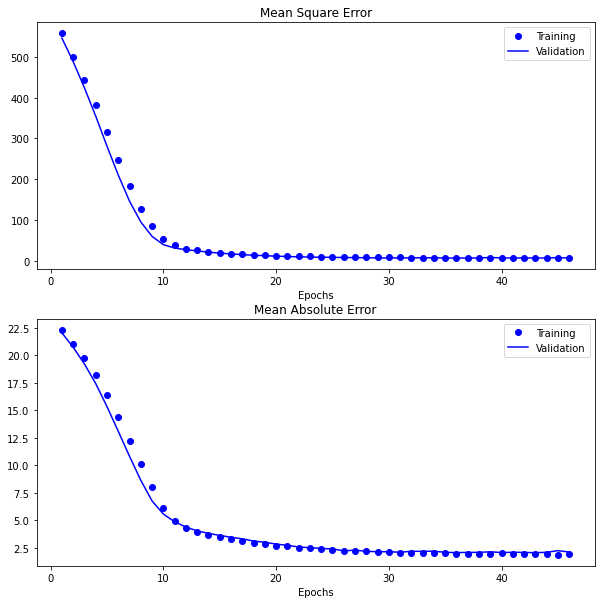

In [11]:
print('Show history')
history_dict = history.history
h_mae = history_dict['mae']
h_val_mae = history_dict['val_mae']
h_mse = history_dict['mse']
h_val_mse = history_dict['val_mse']

epochs = range(1, len(h_mae) + 1)

plt.figure(figsize=(10,10))

plt.subplot(211) # show loss history
plt.plot(epochs, h_mse, 'bo', label='Training')
plt.plot(epochs, h_val_mse, 'b', label='Validation')
plt.title('Mean Square Error')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(212) # show accuracy history
plt.plot(epochs, h_mae, 'bo', label='Training')
plt.plot(epochs, h_val_mae, 'b', label='Validation')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()

In [12]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.1905 - mae: 1.7590 - mse: 5.1905
Testing set Mean Abs Error:  1.76 MPG


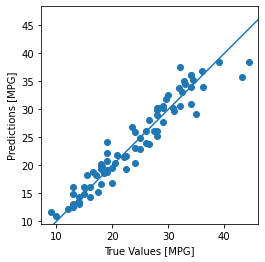

In [13]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 100], [-100, 100])

Text(0, 0.5, 'Count')

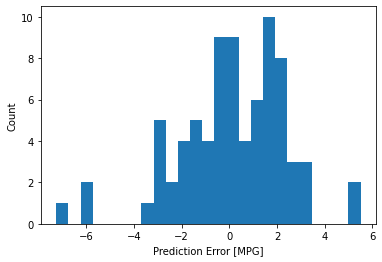

In [14]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")